<a href="https://colab.research.google.com/github/Bibitpamungkas/praktikumML_314_321/blob/Praktikum/Copy_of_Modul_5_Kelompok_Praktikum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Tulis Program Anda Disini!
# Basic Imports
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

# Imports untuk membangun CNN
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/tmp/"

In [ ]:
# jika anda ingin menggunakan kaggle API untuk mengunduh dataset gunakan
# kode berikut untuk membantu anda membuat config kaggle.json
# pastikan anda mendaftar akun kaggle terlebih dahulu
# kemudian menuju halaman my account dan buat token API anda

api_token = {"username":"bibitpamungkas","key":"0b4a500fd9a858ee152de296398002ab"}
import json
import zipfile
import os
with open('/tmp/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /tmp/kaggle.json

In [ ]:
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

100% 1.74G/1.74G [00:13<00:00, 39.8MB/s]
100% 1.74G/1.74G [00:13<00:00, 138MB/s] 


In [ ]:
# Ekstrak dataset

import os
import zipfile

os.makedirs('/tmp/chest-xray-pneumoniacovid19tuberculosis')

local_zip = '/content/chest-xray-pneumoniacovid19tuberculosis.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/chest-xray-pneumoniacovid19tuberculosis')
zip_ref.close()

In [ ]:
import os
base_dir = '/tmp/chest-xray-pneumoniacovid19tuberculosis'
train = os.path.join(base_dir,'train')
validation = os.path.join(base_dir,'val')
test = os.path.join(base_dir,'test')

c19_tr = os.path.join(train,'COVID19')
c19_va = os.path.join(validation,'COVID19')
c19_ts = os.path.join(test,'COVID19')

nr_tr = os.path.join(train,'NORMAL')
nr_va = os.path.join(validation,'NORMAL')
nr_ts = os.path.join(test,'NORMAL')

pn_tr = os.path.join(train,'PNEUMONIA')
pn_va = os.path.join(validation,'PNEUMONIA')
pn_ts = os.path.join(test,'PNEUMONIA')

tb_tr = os.path.join(train,'TURBERCULOSIS')
tb_va = os.path.join(validation,'TURBERCULOSIS')
tb_ts = os.path.join(test,'TURBERCULOSIS')

#file training dan validation
file_train_c19 = os.listdir(c19_tr)
file_validation_c19 = os.listdir(c19_va)
file_test_c19 = os.listdir(c19_ts)
file_train_nr = os.listdir(nr_tr)
file_validation_nr = os.listdir(nr_va)
file_test_nr = os.listdir(nr_ts)
file_train_pn = os.listdir(pn_tr)
file_validation_pn = os.listdir(pn_va)
file_test_pn = os.listdir(pn_ts)
file_train_tb = os.listdir(tb_tr)
file_validation_tb = os.listdir(tb_va)
file_test_tb = os.listdir(tb_ts)

#Print jumlah data training dan validation
print("Data COVID19 Train : " + str(len(file_train_c19)))
print("Data COVID19 Validation : " + str(len(file_validation_c19)))
print("Data COVID19 Test : " + str(len(file_test_c19)))
print("Data NORMAL Train : " + str(len(file_train_nr)))
print("Data NORMAL Validation : " + str(len(file_validation_nr)))
print("Data NORMAL Test : " + str(len(file_test_nr)))
print("Data PNEUMONIA Train : " + str(len(file_train_pn)))
print("Data PNEUMONIA Validation : " + str(len(file_validation_pn)))
print("Data PNEUMONIA Test : " + str(len(file_test_pn)))
print("Data TURBERCULOSIS Train : " + str(len(file_train_tb)))
print("Data TURBERCULOSIS Validation : " + str(len(file_validation_tb)))
print("Data TURBERCULOSIS Test : " + str(len(file_test_tb)))

Data COVID19 Train : 460
Data COVID19 Validation : 10
Data COVID19 Test : 106
Data NORMAL Train : 1341
Data NORMAL Validation : 8
Data NORMAL Test : 234
Data PNEUMONIA Train : 3875
Data PNEUMONIA Validation : 8
Data PNEUMONIA Test : 390
Data TURBERCULOSIS Train : 650
Data TURBERCULOSIS Validation : 12
Data TURBERCULOSIS Test : 41


In [ ]:
# TULIS KODE ANDA DISINI
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size=10

augmen_gen = ImageDataGenerator(rescale=1/255,rotation_range=30, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, 
                        zoom_range=0.8, horizontal_flip=True,
                        fill_mode="nearest")
#melakukan class mode= metode pemilihan clasifikasi, taret size= dimensi citra, batch size= banyak citra yg dimasukkan setiap step, shuffle= acak data tida sesusai alfabetik
train_aug = augmen_gen.flow_from_directory(
    '/tmp/chest-xray-pneumoniacovid19tuberculosis/train',
    class_mode = 'categorical',
    shuffle=True,
    target_size = (50,50),
    batch_size=batch_size,
    color_mode ='rgb'
)

test_aug = augmen_gen.flow_from_directory(
    '/tmp/chest-xray-pneumoniacovid19tuberculosis/test',
    class_mode = 'categorical',
    shuffle=False,
    target_size = (50,50),
    batch_size=batch_size,
    color_mode ='rgb',
)

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


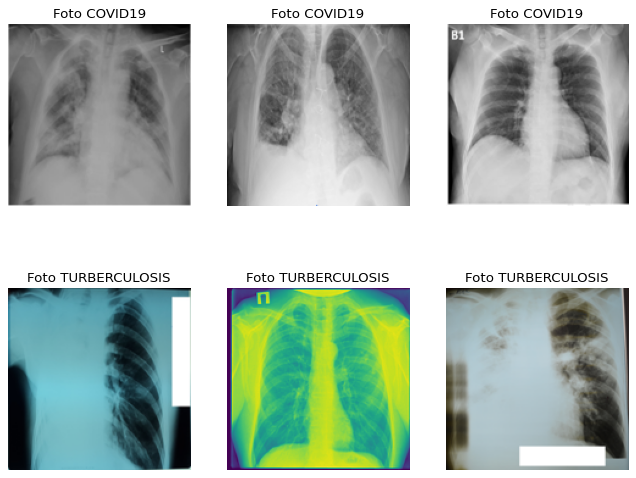

In [ ]:
train_covid19_images = glob(train+"/COVID19/*")
train_turberculosis_images = glob(train+"/TURBERCULOSIS/*")

plt.figure(figsize=(10, 8), dpi=80)
init_subplot = 230
for i in range(1, 7):
    plt.subplot(init_subplot + i)
    
    if i < 4:
        img = Image.open(np.random.choice(train_covid19_images)).resize((150, 150))
        plt.title("Foto COVID19")
    else:
        img = Image.open(np.random.choice(train_turberculosis_images)).resize((150, 150))
        plt.title("Foto TURBERCULOSIS")
    
    img = np.asarray(img)
    plt.axis('off')
    plt.imshow(img)



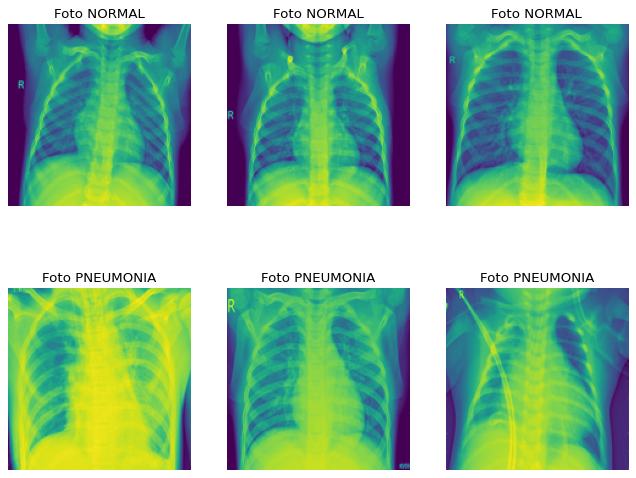

In [ ]:
train_normal_images = glob(train+"/NORMAL/*")
train_pneumonia_images = glob(train+"/PNEUMONIA/*")

plt.figure(figsize=(10, 8), dpi=80)
init_subplot = 230

for j in range(1,7):
    plt.subplot(init_subplot + j)

    if j < 4:
        img = Image.open(np.random.choice(train_normal_images)).resize((150, 150))
        plt.title("Foto NORMAL")
    else:
        img = Image.open(np.random.choice(train_pneumonia_images)).resize((150, 150))
        plt.title("Foto PNEUMONIA")
    
    img = np.asarray(img)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
IMAGE_SIZE = [50, 50]

categories = ["COVID19", "NORMAL","PNEUMONIA","TURBERCULOSIS"]

In [ ]:
# Menambahkan Layer untuk Preprocessing pada VGG
vgg = VGG19(input_shape = IMAGE_SIZE + [3], 
            weights = 'imagenet',
            include_top=False)


# Untuk perintah menolak men training data yang telah digunakan sebelumnya
for layer in vgg.layers:
  layer.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)

# Lapisan Terakhir dengan aktivasi softmax untuk output biner 
prediction = Dense(len(categories), activation='softmax')(x)

In [ ]:
# Membuat obbjek model 
model = Model(inputs=vgg.input, outputs=prediction)

# Melihat struktur model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
from tensorflow.keras.optimizers import Adam
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy']
)

In [ ]:
# Mencocokan model
r = model.fit_generator(
  train_aug,
  validation_data=test_aug,
  epochs=100,
  steps_per_epoch=len(train_aug), 
  validation_steps=len(test_aug)
)       

Epoch 1/100
633/633 [==============================] - 125s 181ms/step - loss: 0.7682 - accuracy: 0.6968 - val_loss: 0.7811 - val_accuracy: 0.6900
Epoch 2/100
633/633 [==============================] - 111s 176ms/step - loss: 0.6702 - accuracy: 0.7319 - val_loss: 0.8331 - val_accuracy: 0.6329
Epoch 3/100
633/633 [==============================] - 111s 175ms/step - loss: 0.6241 - accuracy: 0.7529 - val_loss: 0.8262 - val_accuracy: 0.6524
Epoch 4/100
633/633 [==============================] - 122s 192ms/step - loss: 0.6110 - accuracy: 0.7607 - val_loss: 0.9391 - val_accuracy: 0.6109
Epoch 5/100
633/633 [==============================] - 112s 177ms/step - loss: 0.5793 - accuracy: 0.7732 - val_loss: 0.7575 - val_accuracy: 0.6939
Epoch 6/100
633/633 [==============================] - 111s 175ms/step - loss: 0.5645 - accuracy: 0.7836 - val_loss: 0.8166 - val_accuracy: 0.6848
Epoch 7/100
633/633 [==============================] - 111s 175ms/step - loss: 0.5598 - accuracy: 0.7779 - val_loss: 0

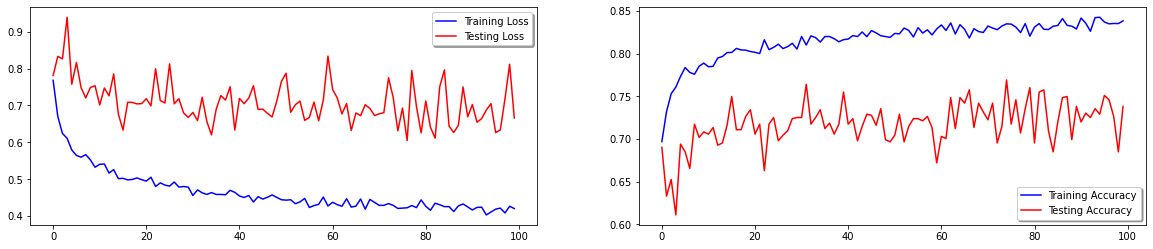

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4), nrows=1, ncols=2)  

ax[0].plot(r.history['loss'], color='b', label="Training Loss")
ax[0].plot(r.history['val_loss'], color='r', label="Testing Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(r.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(r.history['val_accuracy'], color='r',label="Testing Accuracy")
legend = ax[1].legend(loc='best', shadow=True)  

In [ ]:
from sklearn.metrics import classification_report
ypred = model.predict(test_aug)
prediction = np.argmax(ypred, axis=1)
print(classification_report(test_aug.classes, prediction))

              precision    recall  f1-score   support

           0       0.76      0.49      0.60       106
           1       0.90      0.48      0.63       234
           2       0.72      0.97      0.82       390
           3       0.63      0.78      0.70        41

    accuracy                           0.74       771
   macro avg       0.75      0.68      0.69       771
weighted avg       0.77      0.74      0.73       771



In [ ]:
import tensorflow as tf
# (to generate a SavedModel) 
tf.saved_model.save(model, "saved_model_keras_dir")

INFO:tensorflow:Assets written to: saved_model_keras_dir/assets


In [ ]:
from tensorflow.keras.layers import Dense
import tensorflow as tf
tf.keras.applications.densenet.DenseNet169(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000
)

58556416/58541896 [==============================] - 1s 0us/step


In [ ]:
H = model.fit_generator(
  train_aug,
  validation_data=test_aug,
  epochs=100,
  steps_per_epoch=len(train_aug),
  validation_steps=len(test_aug)
)      

Epoch 1/100
633/633 [==============================] - 121s 177ms/step - loss: 0.7889 - accuracy: 0.6884 - val_loss: 0.8301 - val_accuracy: 0.6368
Epoch 2/100
633/633 [==============================] - 109s 173ms/step - loss: 0.6598 - accuracy: 0.7419 - val_loss: 0.8708 - val_accuracy: 0.6615
Epoch 3/100
633/633 [==============================] - 106s 168ms/step - loss: 0.6378 - accuracy: 0.7433 - val_loss: 0.7246 - val_accuracy: 0.7108
Epoch 4/100
633/633 [==============================] - 108s 171ms/step - loss: 0.6214 - accuracy: 0.7442 - val_loss: 0.7545 - val_accuracy: 0.7017
Epoch 5/100
633/633 [==============================] - 108s 171ms/step - loss: 0.5757 - accuracy: 0.7721 - val_loss: 0.7890 - val_accuracy: 0.6615
Epoch 6/100
633/633 [==============================] - 109s 172ms/step - loss: 0.5943 - accuracy: 0.7648 - val_loss: 0.7614 - val_accuracy: 0.7082
Epoch 7/100
633/633 [==============================] - 108s 171ms/step - loss: 0.5506 - accuracy: 0.7844 - val_loss: 0

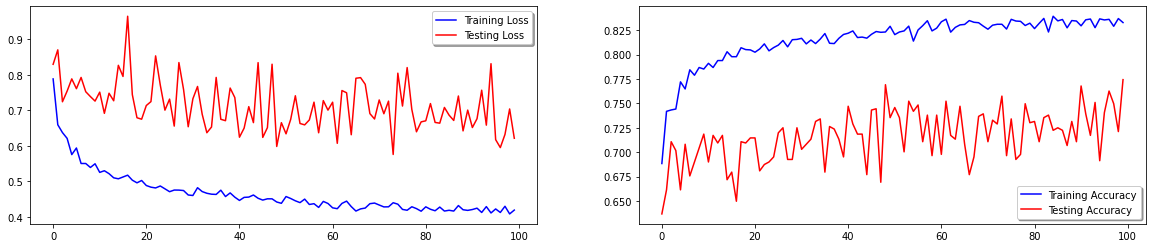

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4), nrows=1, ncols=2)

ax[0].plot(H.history['loss'], color='b', label="Training Loss")
ax[0].plot(H.history['val_loss'], color='r', label="Testing Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(H.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(H.history['val_accuracy'], color='r',label="Testing Accuracy")
legend = ax[1].legend(loc='best', shadow=True) 

In [ ]:
from sklearn.metrics import classification_report
ypred = model.predict(test_aug)
prediction = np.argmax(ypred, axis=1)
print(classification_report(test_aug.classes, prediction))

              precision    recall  f1-score   support

           0       0.75      0.52      0.61       106
           1       0.74      0.59      0.66       234
           2       0.78      0.88      0.83       390
           3       0.50      0.88      0.64        41

    accuracy                           0.74       771
   macro avg       0.69      0.72      0.68       771
weighted avg       0.75      0.74      0.74       771



In [ ]:
# (to generate a SavedModel) 
tf.saved_model.save(model, "saved_model_keras_dir")

INFO:tensorflow:Assets written to: saved_model_keras_dir/assets
